### Practical 2: Medical Image Analysis

The dataset of this practical is Chest X-Ray Image Classification (Pneumonia) which I obtained from the Kaggle - Chest X-Ray Dataset, using TensorFlow's Keras API.

#### Content

The dataset is organized into 3 folders (train, test, val) and contains subfolders of each image category (Pneumonia / Normal). There are 5,863 X-Ray images (JPEG) and 2 categories(Pneumonia/Normal)

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third exper

Necessary Libraries are:
* TensorFlow
* Keras
* Numpy
* Hyperas, Hyperopt
* Matplotlib, Seaborn

### Data Analysis

In [42]:
pip install tf-explain

Note: you may need to restart the kernel to use updated packages.


In [50]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tf_explain.core.integrated_gradients import IntegratedGradients
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image
from IPython.display import display
import cv2
import itertools
import sklearn.metrics as metrics
import time

In [2]:
data_folder = 'chest_xray'
set_list = ['train','test','val']

In [3]:
normal = []
pneumonia = []
image_count = 0
#size of dataset
for i, _set in enumerate(set_list):
    normal_count = len(os.listdir(os.path.join(data_folder, _set, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(data_folder, _set, 'PNEUMONIA')))
    normal.append(normal_count)
    pneumonia.append(pneumonia_count)
    image_count += normal_count + pneumonia_count
    print('{} dataset has {} images: {} Normal and {} Infected'.format(
          _set, normal_count + pneumonia_count, normal_count, pneumonia_count))

train dataset has 5216 images: 1341 Normal and 3875 Infected
test dataset has 624 images: 234 Normal and 390 Infected
val dataset has 16 images: 8 Normal and 8 Infected


C:\Users\adea\AppData\Local\Temp\ipykernel_47024\2948882226.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=set_list, y=total_images, palette=palette)


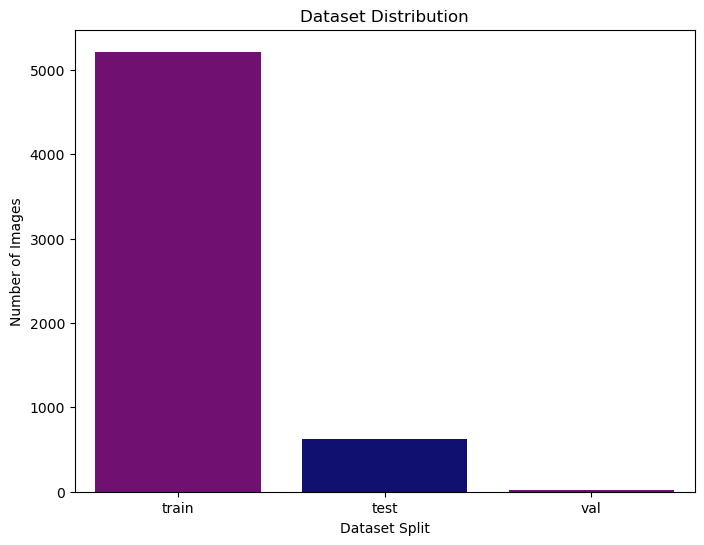

In [4]:
total_images = [normal[i] + pneumonia[i] for i in range(len(set_list))]

palette = {'train': 'purple', 'val': 'purple', 'test': 'navy'}
plt.figure(figsize=(8,6))
sns.barplot(x=set_list, y=total_images, palette=palette)
plt.title('Dataset Distribution')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.show()

C:\Users\adea\AppData\Local\Temp\ipykernel_47024\2996835067.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Normal', 'Pneumonia'], y=[normal_total, pneumonia_total], palette=['purple', 'navy'])


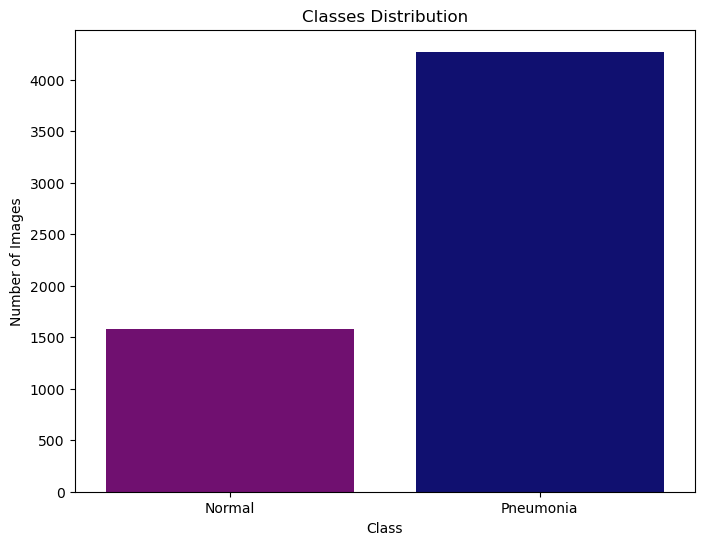

In [5]:
normal_total = normal[0] + normal[1] + normal[2]
pneumonia_total = pneumonia[0] + pneumonia[1] + pneumonia[2]

plt.figure(figsize=(8,6))
sns.barplot(x=['Normal', 'Pneumonia'], y=[normal_total, pneumonia_total], palette=['purple', 'navy'])
plt.title('Classes Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

It looks like the training set has a large number of images, the test set has fewer and the validation set is extremely small. With only a handful of images in the validation set, it might be difficut to get a reliable measue of how well the model is generalizing during the training. We risk overfitting or underfitting because we dont have enought validation examples to tune hyperparameters. One common approach si to merge the exisiting training and validation sets, then re-spliting them into a new training/validation split. This way we can ensure a larger, more representative validation test. 

In [6]:
#merging and respliting the data
merged_data = []
for split in ['train', 'val']:
    for label in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(data_folder, split, label)
        for filename in os.listdir(folder):
            if filename.lower().endswith('.jpeg'):
                file_path = os.path.join(folder, filename)
                merged_data.append({'filepath': file_path, 'label': 0 if label == 'NORMAL' else 1})

print("Total merged train/val images:", len(merged_data))

random.shuffle(merged_data)

split_index = int(0.8 * len(merged_data))
train_data1 = merged_data[:split_index]
val_data1 = merged_data[split_index:]

print("New Train Data: {} images".format(len(train_data1)))
print("New Validation Data: {} images".format(len(val_data1)))


Total merged train/val images: 5232
New Train Data: 4185 images
New Validation Data: 1047 images


In [7]:
def count_classes(data):
    normal_count = sum(1 for d in data if d['label'] == 0)
    pneumonia_count = sum(1 for d in data if d['label'] == 1)
    return normal_count, pneumonia_count
train_normal, train_pneumonia = count_classes(train_data1)
val_normal, val_pneumonia = count_classes(val_data1)

print("New Train: {} Normal, {} Pneumonia".format(train_normal, train_pneumonia))
print("New Val: {} Normal, {} Pneumonia".format(val_normal, val_pneumonia))

New Train: 1083 Normal, 3102 Pneumonia
New Val: 266 Normal, 781 Pneumonia


In [8]:
def load_test_data(data_folder):
    test_data = []
    test_folder = os.path.join(data_folder, 'test')
    for label in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(test_folder, label)
        for filename in os.listdir(folder):
            if filename.lower().endswith('.jpeg'):
                file_path = os.path.join(folder, filename)
                test_data.append({'filepath': file_path, 'label': 0 if label=='NORMAL' else 1})
    return test_data

test_data = load_test_data(data_folder)

Given the total number of images we have, a 80/20 split is a resonable approach. The training set has 4185 images and validation has 1047 images. 

In [9]:
test_normal, test_pneumonia = count_classes(merged_data)
categories = ['Normal', 'Pneumonia']
n_train = [train_normal, train_pneumonia]
n_val = [val_normal, val_pneumonia]
n_test = [test_normal, test_pneumonia]

distribution_df = pd.DataFrame({
    'Category': categories,
    'Train': n_train,
    'Validation': n_val,
    'Test': n_test
})

# Display the table
print(distribution_df)


    Category  Train  Validation  Test
0     Normal   1083         266  1349
1  Pneumonia   3102         781  3883


C:\Users\adea\AppData\Local\Temp\ipykernel_47024\32748143.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=set_list, y=dataset_counts, palette=palette_ds)


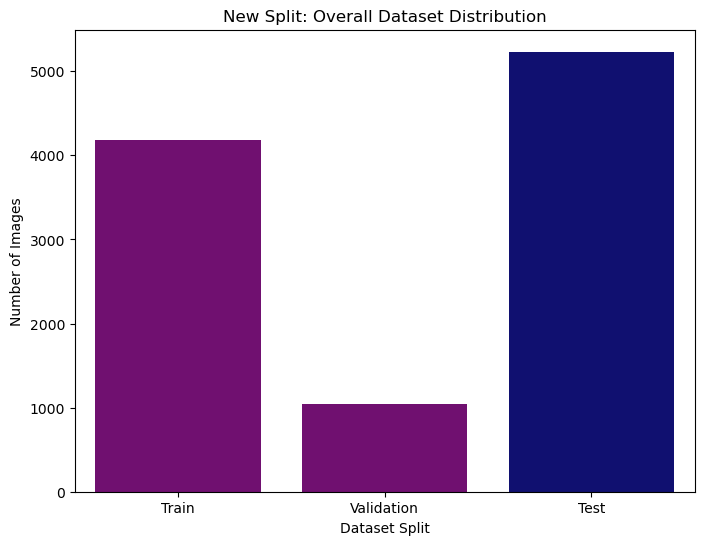

C:\Users\adea\AppData\Local\Temp\ipykernel_47024\32748143.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Normal', 'Pneumonia'], y=[normal_total, pneumonia_total], palette=['purple', 'navy'])


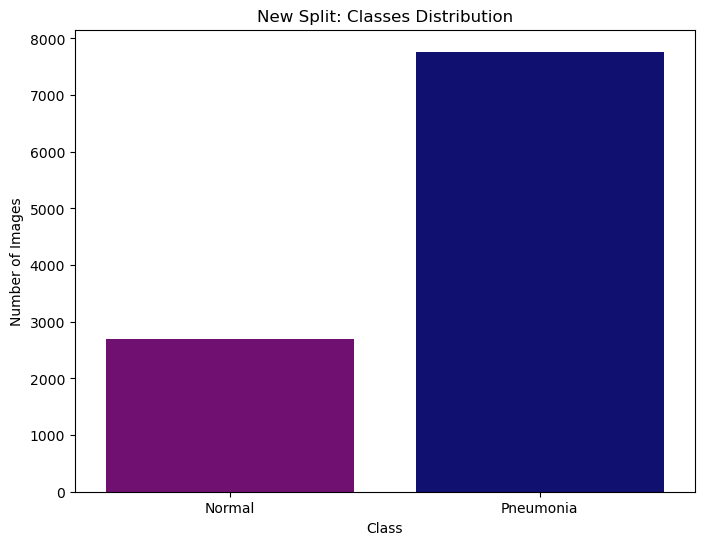

In [10]:
# Overall Dataset Distribution 
set_list = ['Train', 'Validation', 'Test']
train_total = 4185
val_total = 1047
test_total = 5232
dataset_counts = [train_total, val_total, test_total]
# overall dataset distribution
plt.figure(figsize=(8,6))
palette_ds = {'Train': 'purple', 'Validation': 'purple', 'Test': 'navy'}
sns.barplot(x=set_list, y=dataset_counts, palette=palette_ds)
plt.title('New Split: Overall Dataset Distribution')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.show()


# Classes Distribution
normal_total = 1099 + 250 + 1349   
pneumonia_total = 3086 + 797 + 3883  
#  overall class distribution
plt.figure(figsize=(8,6))
sns.barplot(x=['Normal', 'Pneumonia'], y=[normal_total, pneumonia_total], palette=['purple', 'navy'])
plt.title('New Split: Classes Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


Image DataFrame head:
                                            filepath   category  width  height
0  chest_xray\train\PNEUMONIA\person1204_bacteria...  Pneumonia   1280     808
1  chest_xray\train\PNEUMONIA\person97_virus_181....  Pneumonia   1056     808
2  chest_xray\train\PNEUMONIA\person1143_virus_18...  Pneumonia    928     720
3          chest_xray\train\NORMAL\IM-0285-0001.jpeg     Normal   1426    1101
4  chest_xray\train\PNEUMONIA\person293_virus_604...  Pneumonia    570     305


C:\Users\adea\AppData\Local\Temp\ipykernel_47024\2304520228.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset["height"], label=f"{cat} Height", shade=True)
C:\Users\adea\AppData\Local\Temp\ipykernel_47024\2304520228.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset["width"], label=f"{cat} Width", shade=True)
C:\Users\adea\AppData\Local\Temp\ipykernel_47024\2304520228.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset["height"], label=f"{cat} Height", shade=True)
C:\Users\adea\AppData\Local\Temp\ipykernel_47024\2304520228.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; se

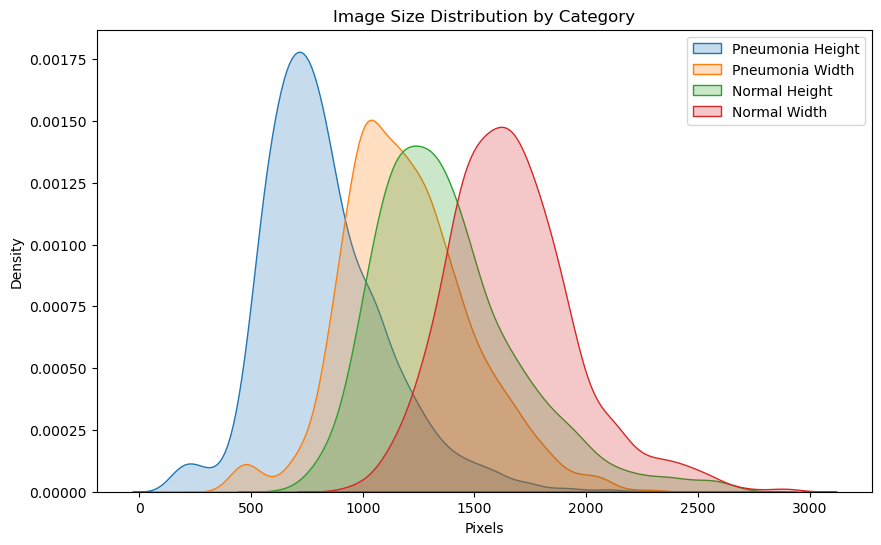

In [11]:
# visual checking of image dimensions
data_list = []
for d in merged_data:
    fp = d['filepath']
    try:
        img = Image.open(fp)
        width, height = img.size
        category = 'Normal' if d['label'] == 0 else 'Pneumonia'
        data_list.append({'filepath': fp, 'category': category, 'width': width, 'height': height})
    except Exception as e:
        print("Error processing image:", fp, e)

image_df = pd.DataFrame(data_list)
print("Image DataFrame head:")
print(image_df.head())

# plotting the distribution of image sizes (height and width) by category

plt.figure(figsize=(10,6))
for cat in image_df['category'].unique():
    subset = image_df[image_df['category'] == cat]
    sns.kdeplot(subset["height"], label=f"{cat} Height", shade=True)
    sns.kdeplot(subset["width"], label=f"{cat} Width", shade=True)

plt.xlabel("Pixels")
plt.ylabel("Density")
plt.title("Image Size Distribution by Category")
plt.legend()
plt.show()


**Interpretation of the Plot:**  
This plot displays the kernel density estimates (KDEs) of the image height and width distributions for each category (Normal and Pneumonia) in our new training (or validation/test) split. The KDE curves provide a smoothed representation of the distribution of pixel dimensions, showing where most images tend to cluster in terms of size. Peaks in the curves indicate the most common image dimensions, while the spread shows the variability among the images. By comparing the curves between the Normal and Pneumonia classes, we can assess whether there are significant differences in their average sizes or resolution distributions. This visual analysis helps confirm if the images are consistently sized and whether additional preprocessing (e.g., resizing) may be necessary before model training.


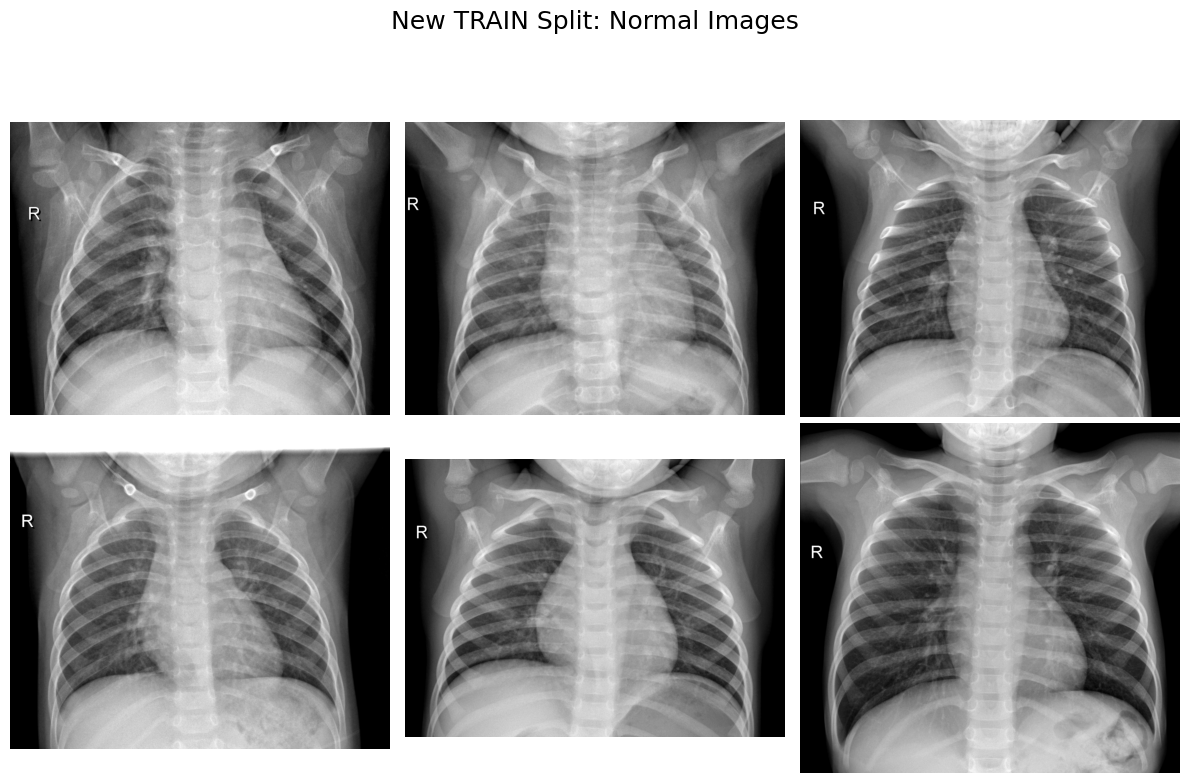

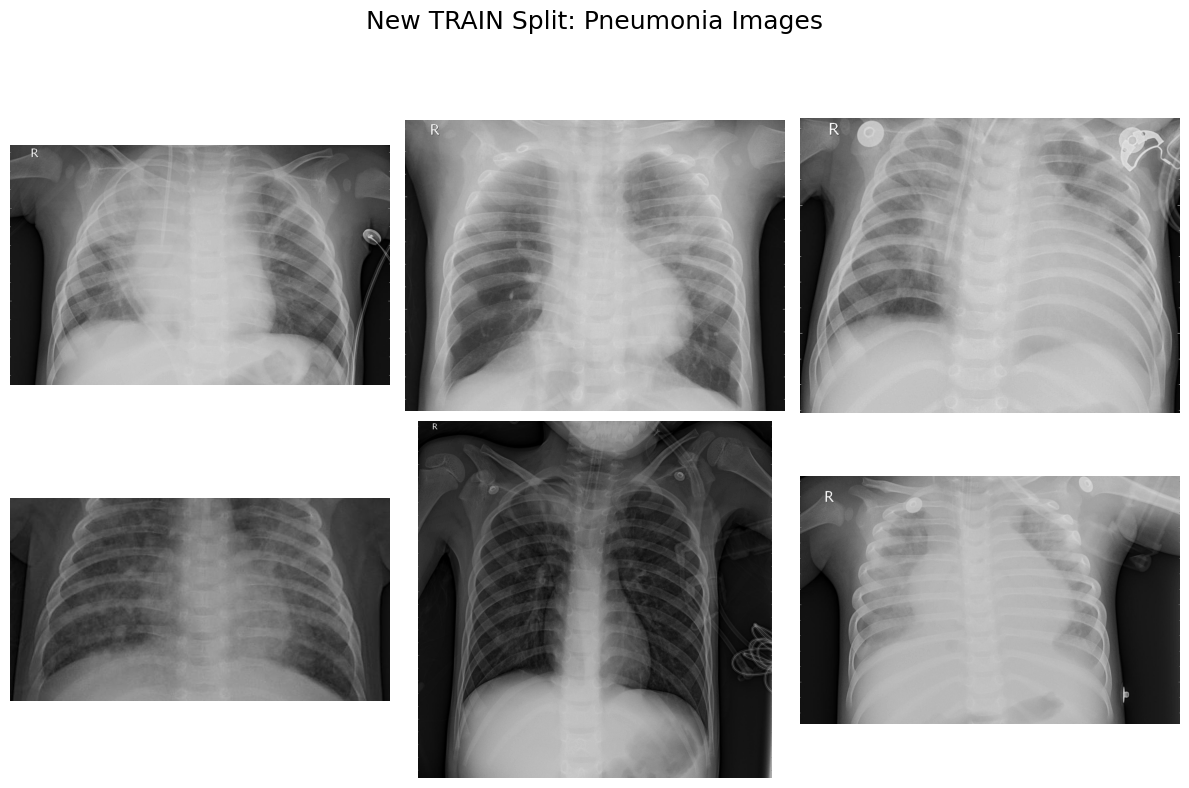

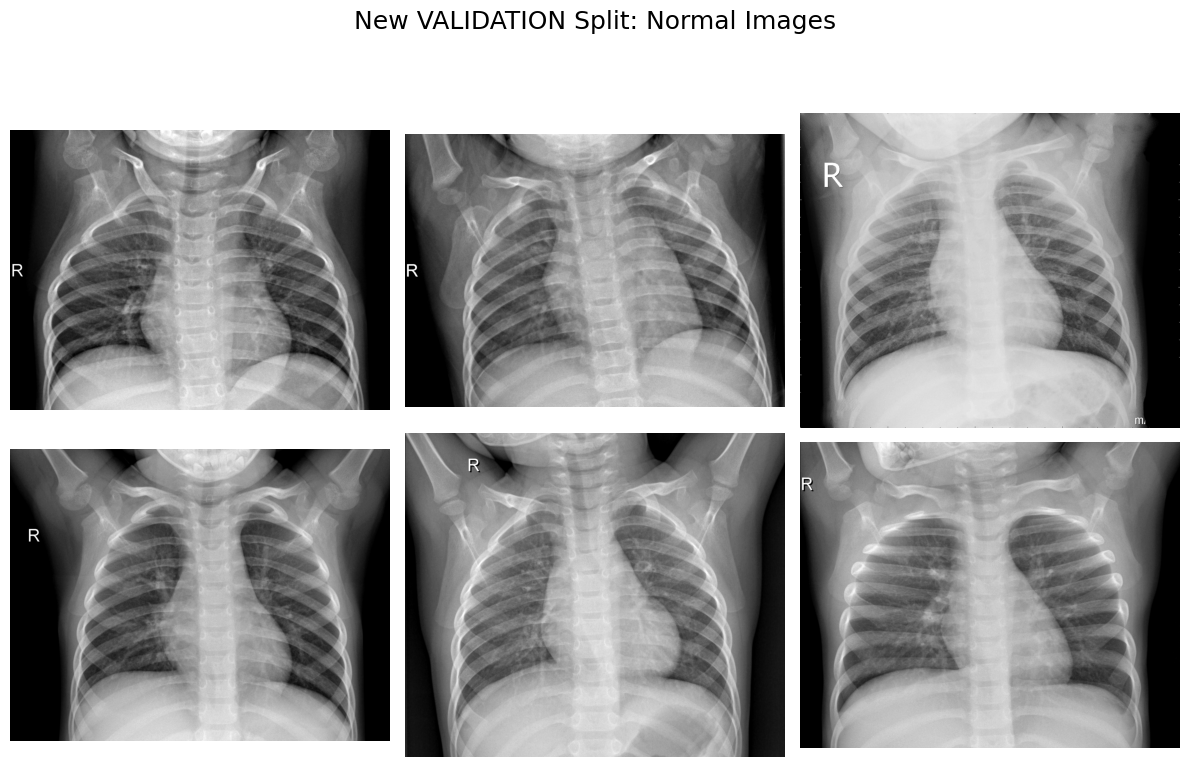

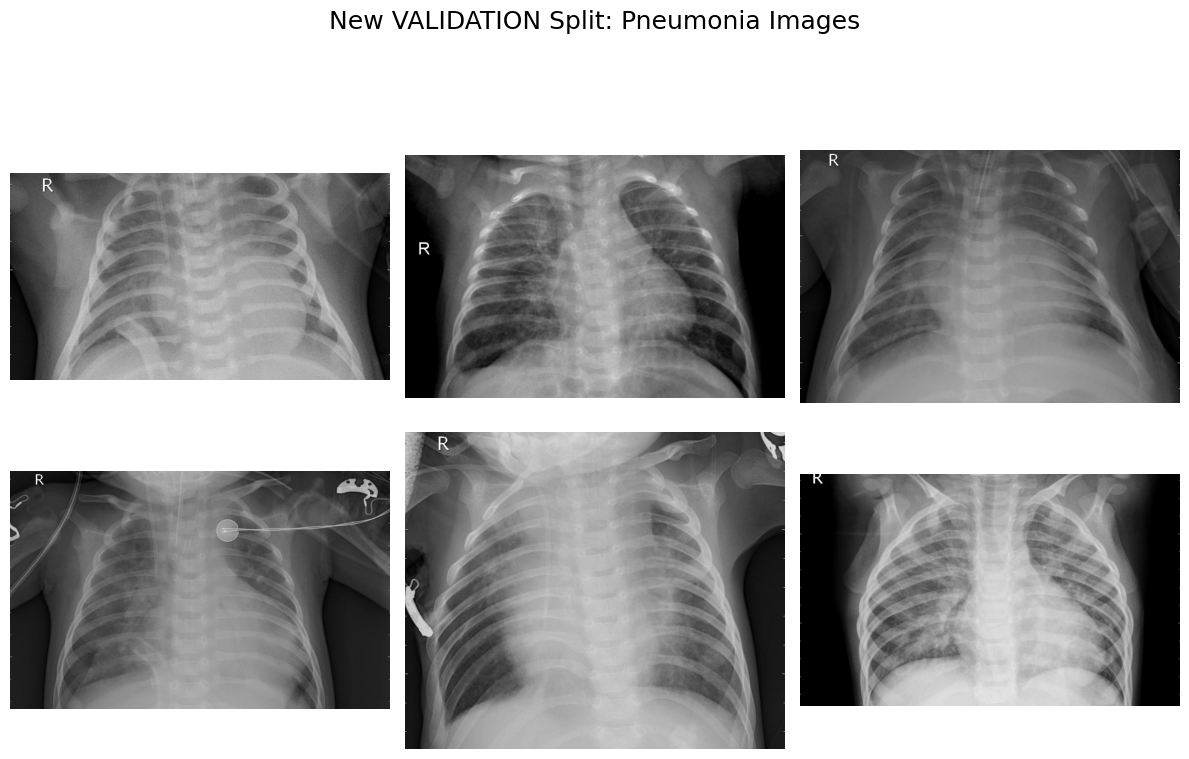

In [12]:
def display_images_grid(image_paths, title, n_rows=2, n_cols=3, cmap='gray'):
    n_images = min(len(image_paths), n_rows * n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    fig.suptitle(title, fontsize=18)
    
    if n_rows * n_cols == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    for idx in range(n_rows * n_cols):
        if idx < n_images:
            try:
                img = Image.open(image_paths[idx])
                axs[idx].imshow(img, cmap=cmap)
            except Exception as e:
                print("Error loading image:", image_paths[idx], e)
                axs[idx].text(0.5, 0.5, 'Error loading image', 
                              horizontalalignment='center', verticalalignment='center')
            axs[idx].axis('off')
        else:
            axs[idx].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# visual Checking for new TRAIN Split:
train_normal_paths = [d['filepath'] for d in train_data1 if d['label'] == 0]
train_pneumonia_paths = [d['filepath'] for d in train_data1 if d['label'] == 1]

if train_normal_paths and train_pneumonia_paths:
    display_images_grid(train_normal_paths, "New TRAIN Split: Normal Images", n_rows=2, n_cols=3, cmap='gray')
    display_images_grid(train_pneumonia_paths, "New TRAIN Split: Pneumonia Images", n_rows=2, n_cols=3, cmap='gray')
else:
    print("Not enough images in New TRAIN data for visual checking.")

# visual Checking for New VALIDATION Split:
val_normal_paths = [d['filepath'] for d in val_data1 if d['label'] == 0]
val_pneumonia_paths = [d['filepath'] for d in val_data1 if d['label'] == 1]

if val_normal_paths and val_pneumonia_paths:
    display_images_grid(val_normal_paths, "New VALIDATION Split: Normal Images", n_rows=2, n_cols=3, cmap='gray')
    display_images_grid(val_pneumonia_paths, "New VALIDATION Split: Pneumonia Images", n_rows=2, n_cols=3, cmap='gray')
else:
    print("Not enough images in New VALIDATION data for visual checking.")


All images are clena and we dont have any black stops, jewlery, medical equipment. 

Normal Image Format: JPEG
Normal Image Size: (1426, 1101)
Pneumonia Image Format: JPEG
Pneumonia Image Size: (1280, 808)


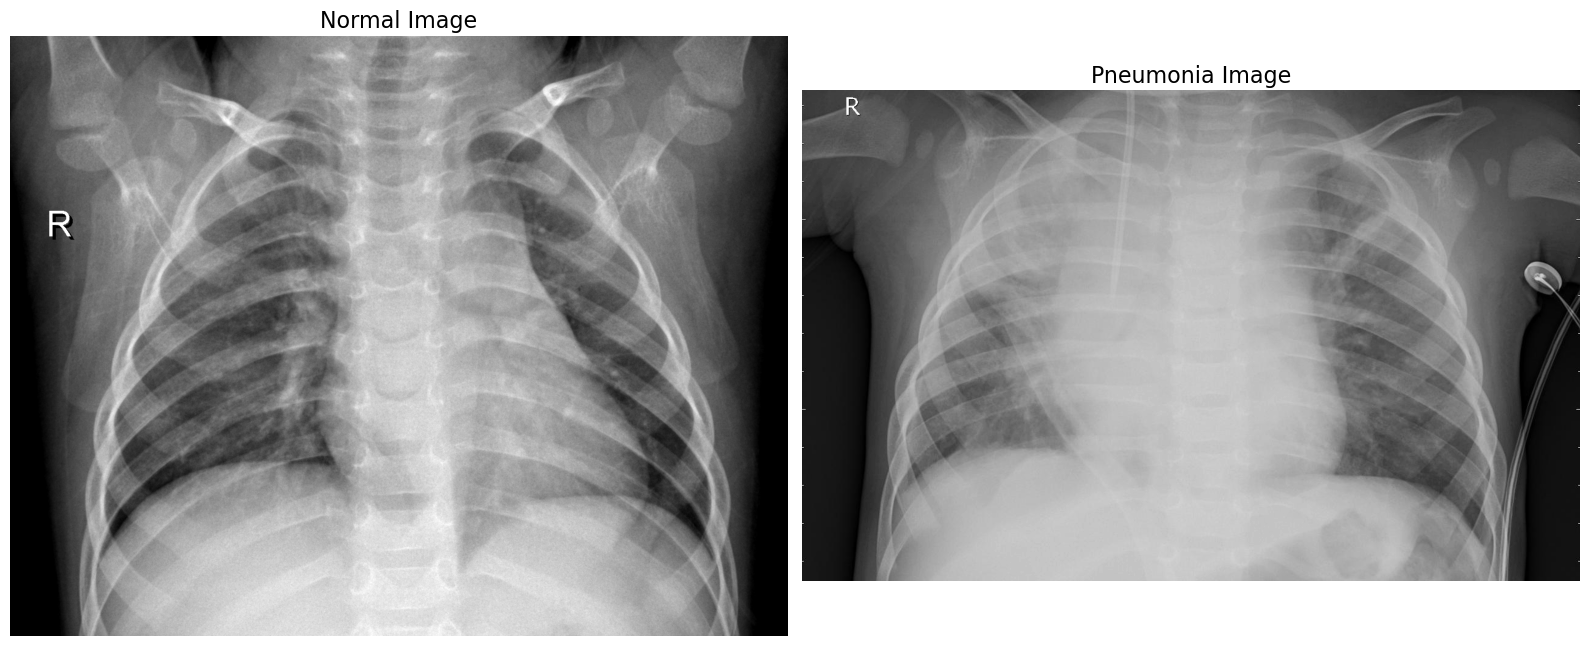

In [13]:
m_normal = Image.open(train_normal_paths[0])
print("Normal Image Format:", m_normal.format)
print("Normal Image Size:", m_normal.size)

im_pneumonia = Image.open(train_pneumonia_paths[0])
print("Pneumonia Image Format:", im_pneumonia.format)
print("Pneumonia Image Size:", im_pneumonia.size)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(m_normal, cmap='gray')
ax[0].set_title("Normal Image", fontsize=16)
ax[0].axis('off') 
ax[1].imshow(im_pneumonia, cmap='gray')
ax[1].set_title("Pneumonia Image", fontsize=16)
ax[1].axis('off') 
plt.tight_layout()
plt.show()

Pneumonia positive images seems to be more faint as the borders between organs are less sharp because of the soft tissue in the lungs (water). Because X-rays cannot pass through fluid as easily as they pass through air, these areas look hazy or “faint,” and the usual sharp contrasts between structures—like lung fields, blood vessels, and organ borders—become blurred. In contrast, a normal chest X-ray shows well-aerated lungs, allowing for clearer visibility of lung markings and sharper boundaries around the heart, diaphragm, and other tissues. In pneumonia, the replacement of air with fluid diminishes this contrast, creating a hazier overall appearance and obscuring the fine details you would otherwise expect to see in a healthy lung

### Build Dataset for Model Training

Memory - Efficient Pipeline

In [14]:
def process_path(file_path, label, image_size=(224,224)):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    return image, label

def create_dataset(file_paths, labels, image_size=(224,224), batch_size=16, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(lambda fp, lbl: process_path(fp, lbl, image_size=image_size),
                num_parallel_calls=2)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_paths))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_filepaths = [d['filepath'] for d in train_data1]
train_labels = [d['label'] for d in train_data1]
val_filepaths = [d['filepath'] for d in val_data1]
val_labels = [d['label'] for d in val_data1]
test_filepaths = [d['filepath'] for d in test_data]
test_labels = [d['label'] for d in test_data]

batch_size = 16
train_ds = create_dataset(train_filepaths, train_labels, image_size=(224,224), batch_size=batch_size, shuffle=True)
val_ds = create_dataset(val_filepaths, val_labels, image_size=(224,224), batch_size=batch_size, shuffle=False)
test_ds = create_dataset(test_filepaths, test_labels, image_size=(224,224), batch_size=batch_size, shuffle=False)

### Build Model VGG, ResNet50 

In [ ]:
def build_model(model_type='VGG16', input_shape=(224,224,3)):
    inputs = tf.keras.Input(shape=input_shape)
    if model_type == 'VGG16':
        x = tf.keras.applications.vgg16.preprocess_input(inputs)
        base = tf.keras.applications.VGG16(include_top=False, weights='imagenet',
                                           input_shape=input_shape, name='vgg16')
        last_conv_layer = 'block5_conv3'
    else:
        raise ValueError("Only VGG16 is supported in this snippet.")
    base.trainable = False
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.last_conv_layer_name = last_conv_layer  
    return model

model = build_model(model_type='VGG16', input_shape=(224,224,3))
model.summary()

print("VGG16 base layers:")
vgg_base = model.get_layer('vgg16')
for layer in vgg_base.layers:
    print(" -", layer.name)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, 224, 224)  │          0 │ input_layer_10[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, 224, 224)  │          0 │ input_layer_10[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_17         │ (None, 224, 224)  │          0 │ input_layer_10[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_5 (Stack)     │ (None, 224, 224,  │          0 │ get_item_15[0][0… │
│                     │ 3)                │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_17[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 224, 224,  │          0 │ stack_5[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     65,664 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

VGG16 base layers:
 - input_layer_11
 - block1_conv1
 - block1_conv2
 - block1_pool
 - block2_conv1
 - block2_conv2
 - block2_pool
 - block3_conv1
 - block3_conv2
 - block3_conv3
 - block3_pool
 - block4_conv1
 - block4_conv2
 - block4_conv3
 - block4_pool
 - block5_conv1
 - block5_conv2
 - block5_conv3
 - block5_pool


In [16]:
# callbacks for training
early_stop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
# training and evaluation
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop_cb, checkpoint_cb])
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)
print("Reduced Validation Accuracy: {:.2f}%".format(val_acc * 100))
print("Reduced Test Accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8733 - loss: 0.4894
Epoch 1: val_loss improved from inf to 0.07601, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 721s 3s/step - accuracy: 0.8735 - loss: 0.4883 - val_accuracy: 0.9704 - val_loss: 0.0760
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9683 - loss: 0.1006
Epoch 2: val_loss did not improve from 0.07601
262/262 ━━━━━━━━━━━━━━━━━━━━ 723s 3s/step - accuracy: 0.9683 - loss: 0.1006 - val_accuracy: 0.9704 - val_loss: 0.0764
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9726 - loss: 0.0714
Epoch 3: val_loss improved from 0.07601 to 0.05989, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 718s 3s/step - accuracy: 0.9726 - loss: 0.0714 - val_accuracy: 0.9790 - val_loss: 0.0599
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9694 - loss: 0.0812
Epoch 4: val_loss did not improve from 0.05989
262/262 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - accuracy: 0.9694 - loss: 0.0812 - val_accuracy: 0.9733 - val_loss: 0.0782
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9733 - loss: 0.0571
Epoch 5: val_loss did not improve from 0.05989
262/262 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.9733 - loss: 0.0571 - val_accuracy: 0.9761 - val_loss: 0.0609
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9830 - loss: 0.0403
Epoch 6: val_loss improved from 0.05989 to 0.05209, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.9830 - loss: 0.0404 - val_accuracy: 0.9809 - val_loss: 0.0521
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9886 - loss: 0.0307
Epoch 7: val_loss improved from 0.05209 to 0.04943, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.9886 - loss: 0.0308 - val_accuracy: 0.9780 - val_loss: 0.0494
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9913 - loss: 0.0290
Epoch 8: val_loss did not improve from 0.04943
262/262 ━━━━━━━━━━━━━━━━━━━━ 701s 3s/step - accuracy: 0.9913 - loss: 0.0290 - val_accuracy: 0.9761 - val_loss: 0.0604
Epoch 9/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9880 - loss: 0.0318
Epoch 9: val_loss did not improve from 0.04943
262/262 ━━━━━━━━━━━━━━━━━━━━ 724s 3s/step - accuracy: 0.9880 - loss: 0.0318 - val_accuracy: 0.9752 - val_loss: 0.0541
Epoch 10/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9884 - loss: 0.0375
Epoch 10: val_loss did not improve from 0.04943
262/262 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.9884 - loss: 0.0375 - val_accuracy: 0.9733 - val_loss: 0.0837
66/66 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9813 - loss: 0.0386
39/39 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.622

In [18]:
# fine tuning 
# unfreeze some layers in the base model for fine-tuning
model.trainable = True

for layer in model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 15
total_epochs = epochs + fine_tune_epochs
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=total_epochs, initial_epoch=epochs, callbacks=[early_stop_cb, checkpoint_cb])

#re-evaulating model
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)
print(" Validation Accuracy: {:.2f}%".format(val_acc * 100))
print(" Test Accuracy: {:.2f}%".format(test_acc * 100))


Epoch 11/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9932 - loss: 0.0198
Epoch 11: val_loss improved from 0.04943 to 0.04594, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 626s 2s/step - accuracy: 0.9932 - loss: 0.0198 - val_accuracy: 0.9809 - val_loss: 0.0459
Epoch 12/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9929 - loss: 0.0218
Epoch 12: val_loss improved from 0.04594 to 0.04565, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.9929 - loss: 0.0218 - val_accuracy: 0.9809 - val_loss: 0.0457
Epoch 13/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9946 - loss: 0.0206
Epoch 13: val_loss did not improve from 0.04565
262/262 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.9946 - loss: 0.0206 - val_accuracy: 0.9809 - val_loss: 0.0457
Epoch 14/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9950 - loss: 0.0217
Epoch 14: val_loss did not improve from 0.04565
262/262 ━━━━━━━━━━━━━━━━━━━━ 542s 2s/step - accuracy: 0.9950 - loss: 0.0217 - val_accuracy: 0.9809 - val_loss: 0.0459
Epoch 15/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9976 - loss: 0.0131
Epoch 15: val_loss improved from 0.04565 to 0.04558, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.9976 - loss: 0.0131 - val_accuracy: 0.9799 - val_loss: 0.0456
Epoch 16/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9956 - loss: 0.0195
Epoch 16: val_loss improved from 0.04558 to 0.04417, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.9956 - loss: 0.0194 - val_accuracy: 0.9799 - val_loss: 0.0442
Epoch 17/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9970 - loss: 0.0148
Epoch 17: val_loss improved from 0.04417 to 0.04398, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.9970 - loss: 0.0148 - val_accuracy: 0.9799 - val_loss: 0.0440
Epoch 18/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9987 - loss: 0.0122
Epoch 18: val_loss did not improve from 0.04398
262/262 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.9987 - loss: 0.0122 - val_accuracy: 0.9799 - val_loss: 0.0440
Epoch 19/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9980 - loss: 0.0150
Epoch 19: val_loss did not improve from 0.04398
262/262 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.9980 - loss: 0.0150 - val_accuracy: 0.9799 - val_loss: 0.0448
Epoch 20/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9959 - loss: 0.0164
Epoch 20: val_loss improved from 0.04398 to 0.04374, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.9959 - loss: 0.0164 - val_accuracy: 0.9799 - val_loss: 0.0437
Epoch 21/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9973 - loss: 0.0161
Epoch 21: val_loss did not improve from 0.04374
262/262 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.9973 - loss: 0.0161 - val_accuracy: 0.9799 - val_loss: 0.0447
Epoch 22/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9965 - loss: 0.0156
Epoch 22: val_loss improved from 0.04374 to 0.04350, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.9965 - loss: 0.0156 - val_accuracy: 0.9809 - val_loss: 0.0435
Epoch 23/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9970 - loss: 0.0141
Epoch 23: val_loss did not improve from 0.04350
262/262 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.9970 - loss: 0.0141 - val_accuracy: 0.9799 - val_loss: 0.0444
Epoch 24/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9979 - loss: 0.0149
Epoch 24: val_loss improved from 0.04350 to 0.04338, saving model to best_model.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 629s 2s/step - accuracy: 0.9979 - loss: 0.0149 - val_accuracy: 0.9819 - val_loss: 0.0434
Epoch 25/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9980 - loss: 0.0123
Epoch 25: val_loss did not improve from 0.04338
262/262 ━━━━━━━━━━━━━━━━━━━━ 709s 3s/step - accuracy: 0.9980 - loss: 0.0123 - val_accuracy: 0.9809 - val_loss: 0.0468
66/66 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.9816 - loss: 0.0343
39/39 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6368 - loss: 1.8505
 Validation Accuracy: 98.19%
 Test Accuracy: 79.01%


### Confusion Matrices for Train, Validation and Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

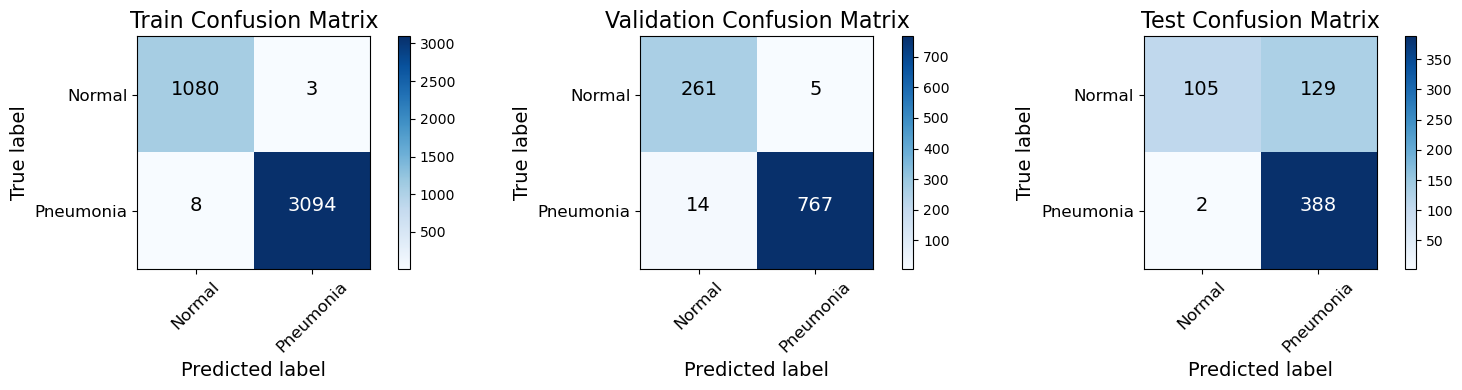

In [19]:
def get_predictions_and_labels(dataset):
    predictions = []
    true_labels = []
    for images, labels in dataset:
        preds = model.predict(images)
        predictions.extend((preds > 0.5).astype(int).flatten())
        true_labels.extend(labels.numpy().flatten())
    return np.array(predictions), np.array(true_labels)

train_preds, train_labels_eval = get_predictions_and_labels(train_ds)
val_preds, val_labels_eval = get_predictions_and_labels(val_ds)
test_preds, test_labels_eval = get_predictions_and_labels(test_ds)
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

train_cm = metrics.confusion_matrix(train_labels_eval, train_preds)
val_cm = metrics.confusion_matrix(val_labels_eval, val_preds)
test_cm = metrics.confusion_matrix(test_labels_eval, test_preds)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plot_confusion_matrix(train_cm, classes=['Normal', 'Pneumonia'], title='Train Confusion Matrix')
plt.subplot(1,3,2)
plot_confusion_matrix(val_cm, classes=['Normal', 'Pneumonia'], title='Validation Confusion Matrix')
plt.subplot(1,3,3)
plot_confusion_matrix(test_cm, classes=['Normal', 'Pneumonia'], title='Test Confusion Matrix')
plt.show()

This image displays three confusion matrices side by side—one each for the training, validation, and test datasets—providing a clear, visual summary of the model's performance in classifying chest X-ray images as either Normal or Pneumonia. The vertical axis represents the true labels while the horizontal axis represents the model's predictions; the diagonal cells show the correct predictions (where the predicted class matches the true class), and the off-diagonal cells indicate misclassifications. In the training and validation matrices, the values along the diagonal are high, reflecting the model’s strong performance on those sets. In contrast, the test confusion matrix reveals a notable discrepancy: a significant number of Normal images are incorrectly predicted as Pneumonia, highlighting a potential bias or area in need of improvement. Overall, the arrangement of the matrices allows clinicians and data scientists to quickly assess the reliability of the model across different data splits, directly identifying where errors are occurring and guiding further refinements.

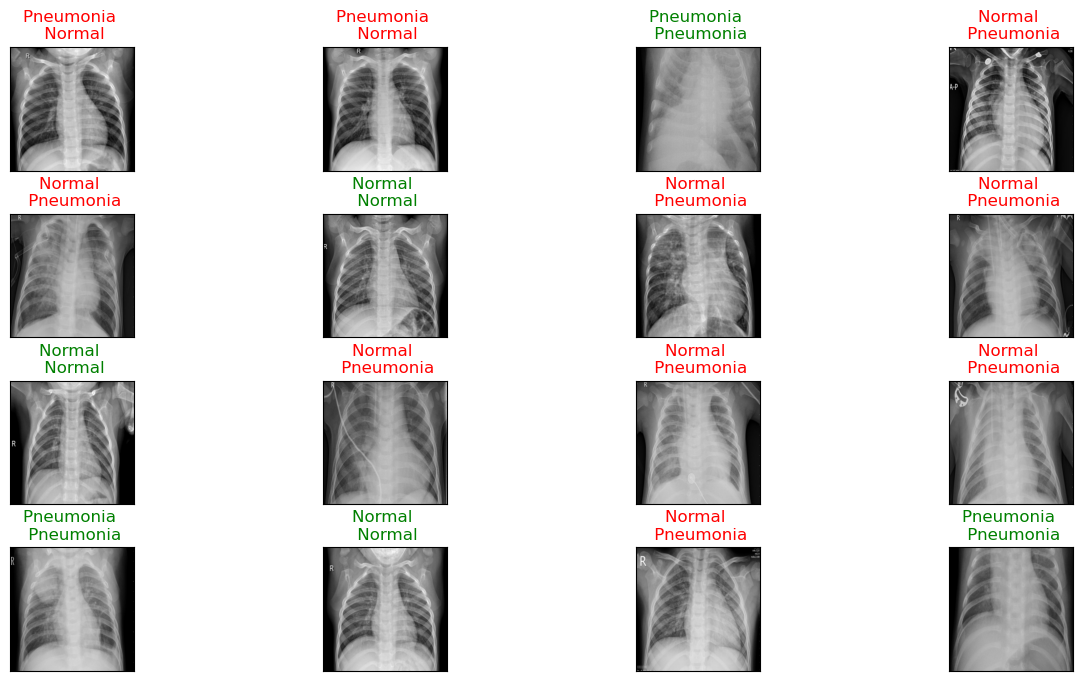

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load validation images from file paths, forcing each image to be RGB.
val_imgs = [np.array(Image.open(fp).convert('RGB').resize((224, 224))) for fp in val_filepaths]
val_imgs = np.array(val_imgs)  # Now this should have the shape (num_images, 224, 224, 3)

# Define the label names for your binary model:
# In your setup, label 0 represents "Normal" and label 1 represents "Pneumonia".
img_labels = ['Normal', 'Pneumonia']

# Plot a grid of 16 random validation images along with predicted and true labels.
fig = plt.figure(figsize=(15, 8))
plt.subplots_adjust(left=0.125, bottom=0.1, wspace=0.4, hspace=0.35)

# Select 16 random indices from the validation images.
indices = np.random.choice(len(val_imgs), size=16, replace=False)
for i, idx in enumerate(indices):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(val_imgs[idx])
    # Convert predictions and true labels to integers
    pred_idx = int(val_preds[idx])
    true_idx = int(val_labels_eval[idx])
    ax.set_title("{} \n {}".format(img_labels[pred_idx], img_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
plt.show()


 Grid of chest X-ray images from a pneumonia classification where each image is labeled by both its predicted class (e.g., “Pneumonia” or “Normal”) and its actual ground-truth class. The text color (green or red) indicates whether the prediction was correct (green) or incorrect (red). In other words, you are seeing a side-by-side comparison of the model’s guess and the true label for each X-ray, making it easy to see which images the model got right or wrong.

## Video Output

Create a video (in either mp4 or avi formats) which iterates through the images (from
both classes) in the test directory and shows the predicted class and the real class (as a
title) for each of the images along with the image. Show this in a way which humans can
read the predictions (perhaps approximately a second per image). This allows clinicians
to easily browse the images and highlights the images which the model does not work
well on. 

In [51]:
label_map = {0: 'Normal', 1: 'Pneumonia'}

output_filename = 'test_predictions.mp4'
fps = 1 
frame_size = (640, 640)  

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video_writer = cv2.VideoWriter(output_filename, fourcc, fps, frame_size)

for fp, true_label in zip(test_filepaths, test_labels):
    img = cv2.imread(fp)
    if img is None:
        print("Error reading image:", fp)
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_input = np.expand_dims(img_resized, axis=0)  # shape becomes (1, 224, 224, 3)

    img_processed = preprocess_input(img_input.astype(np.float32))
    
    pred = model.predict(img_processed)
    pred_label = 1 if pred[0][0] > 0.5 else 0

    overlay_text = f"Pred: {label_map[pred_label]} | True: {label_map[true_label]}"
    frame = cv2.resize(img, frame_size)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    text_size, _ = cv2.getTextSize(overlay_text, font, font_scale, thickness)
    text_x = (frame.shape[1] - text_size[0]) // 2
    text_y = text_size[1] + 10  # margin from top
    text_color = (0, 255, 0) if pred_label == true_label else (0, 0, 255)
    cv2.putText(frame, overlay_text, (text_x, text_y), font, font_scale, text_color, thickness, cv2.LINE_AA)
    
    video_writer.write(frame)

video_writer.release()
print("Video saved as", output_filename)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 